In [14]:
import os
import numpy as np
import mne
import imageio
import h5py
# import scipy.fftpack
import matplotlib
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
# import scipy.io as sio
# from scipy.integrate import simps
import pandas as pd
# from scipy import fft
import matplotlib.mlab as mlab
import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\py_functions')
import NMF_funcs as NMFf
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath

root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance

import h5py
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz

import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

In [15]:
subj = 'EL015'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos
path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
if not os.path.exists(os.path.join(path_infos, subj + "_labels.xlsx")):
    path_infos = os.path.join(path_gen, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient_analysis + '\\' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all


In [4]:
folder = 'InputOutput'

In [16]:
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
######### Load data
rerun = 0
if os.path.isfile(file_con):
    # con_trial
    con_trial = pd.read_csv(file_con)

In [19]:
from datetime import datetime
from datetime import timedelta

# datetime(year, month, day)
sz_time = datetime(2022, 6, 23, 6, 50, 59)

In [50]:
con_trial.SZ  = 'BL'

In [51]:
con_trial.loc[((pd.to_datetime(con_trial['Time'])- sz_time)<timedelta(seconds = 0))& ((pd.to_datetime(con_trial['Time'])- sz_time)>timedelta(seconds = -300)), 'SZ'] = 'preIctal'
con_trial.loc[((pd.to_datetime(con_trial['Time'])- sz_time)<timedelta(seconds = 60))&((pd.to_datetime(con_trial['Time'])- sz_time)>timedelta(seconds = 0)), 'SZ'] = 'Ictal'
con_trial.loc[((pd.to_datetime(con_trial['Time'])- sz_time)<timedelta(seconds = 300))&((pd.to_datetime(con_trial['Time'])- sz_time)>timedelta(seconds = 60)), 'SZ'] = 'postIctal'

In [ ]:
sns.catplot(x= 'Int', y='LL')

In [29]:
df_pivot = con_trial.pivot(index='Chan', columns='Num', values='LL')
df_pivot.fillna(con_trial['LL'].mean(), inplace=True)
V = df_pivot.values

In [55]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']

loading h5


In [72]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((4,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])


In [221]:
labels_clinic[23]

'pH_L1-pH_L2'

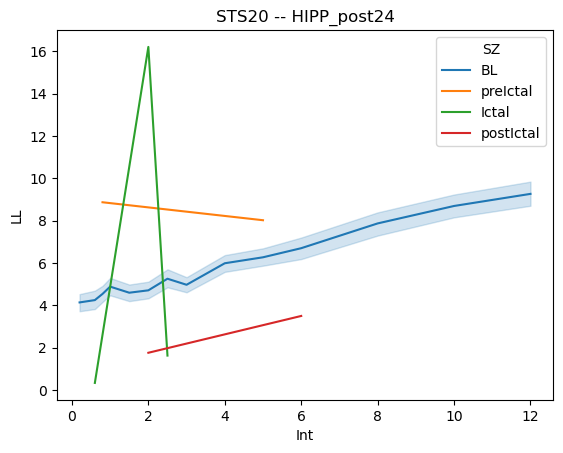

In [223]:
sc = 19
rc = 23
data_plot = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact==0)]
sns.lineplot(x='Int', y= 'LL', hue = 'SZ', data =data_plot, hue_order = ['BL', 'preIctal', 'Ictal', 'postIctal'])
plt.title(labels_all[sc]+ ' -- '+labels_all[rc])
plt.show()


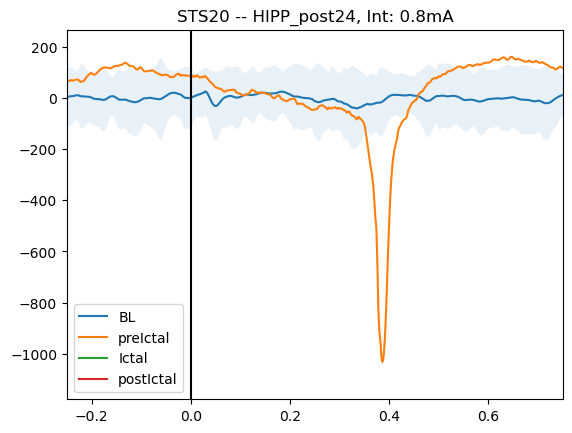

In [231]:
Int = 0.8
for sz_id in ['BL', 'preIctal', 'Ictal', 'postIctal']:
    num = data_plot.loc[(data_plot.Int==Int)&(data_plot.SZ==sz_id), 'Num'].values
    mn = np.mean(EEG_resp[rc, num,:],0)
    resp_std = np.std(EEG_resp[rc, num,:],0)
    plt.plot(x_ax, mn, label = sz_id)
    plt.fill_between(x_ax,mn-resp_std,mn+resp_std, alpha = 0.1)
plt.legend()
plt.xlim([-0.25, 0.75])
plt.title(labels_all[sc]+ ' -- '+labels_all[rc]+', Int: '+str(Int)+'mA')

plt.axvline(0, color=[0,0,0])
plt.show()